In [1]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
import math

tank1 = "tank1-2021-07-04-143149-color.png"
tank5 = "tank5-2021-07-21-103303-color.png"

In [2]:
imageFile = tank5
imageImage = cv.imread(imageFile)

In [3]:
corrected = cv.cvtColor(imageImage, cv.COLOR_BGR2RGB)

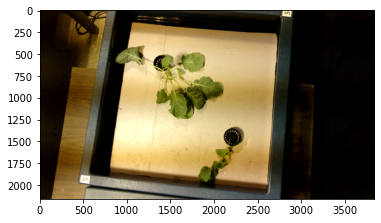

In [4]:
plt.imshow(corrected)
plt.show()



In [5]:
lgreen = (24, 80, 40)
dgreen = (70, 255, 255)

hsvImage = cv.cvtColor(imageImage, cv.COLOR_BGR2HSV)
mask = cv.inRange(hsvImage, lgreen, dgreen)

In [6]:

result = cv.bitwise_and(corrected,corrected,mask=mask)

In [7]:
# this takes about 30 seconds with the tank5 image.
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN

# Get all x, y coordinates of white pixels in the mask
x, y = np.where(mask == 255)
zipped = np.column_stack((x, y))
scaled = StandardScaler().fit_transform(zipped)
max_distance=0.05
min_cluster_size = 100
db = DBSCAN(eps=max_distance, min_samples=min_cluster_size, n_jobs=-1).fit(scaled)


In [8]:
# Number of clusters
n_clusters = len(set(db.labels_)) - (1 if -1 in db.labels_ else 0)
h, w = mask.shape
label_img = np.zeros((h, w), np.uint8)

label_tuples = [[] for x in range(n_clusters)]

for z in range(0, len(db.labels_)):
    if db.labels_[z] > 0:
        label_tuples[db.labels_[z]].append((zipped[z][0],zipped[z][1]))


    if not db.labels_[z] == -1: 
            # Add a cluster with a unique label color to the cluster image
            label_img[zipped[z][0], zipped[z][1]] = db.labels_[z]
            
            
            
            

24.459433040078203 43.41642228739003 1023 1023 1023
29.537889353788934 48.78568107856811 4302 4302 4253
24.535406403940886 80.32543103448276 3248 3248 3248
28.089005235602095 242.49214659685865 191 191 191
30.08850582068452 129.07291127310384 343774 343774 331281


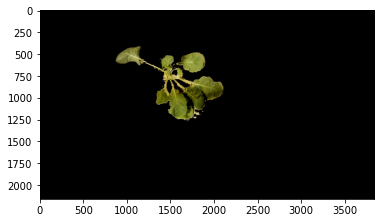

34.364908854166664 49.73046875 3072 3072 1588
24.694330320460146 80.17067730954338 17038 17038 17029
36.477064220183486 42.596330275229356 109 109 46
24.99122807017544 51.60526315789474 114 114 114
28.66260162601626 57.052845528455286 246 246 215
24.792 96.024 125 125 125
24.244755244755243 66.18181818181819 143 143 143
28.987179487179485 47.1025641025641 78 78 78
28.79741157873938 96.43831258644536 50610 50610 50609


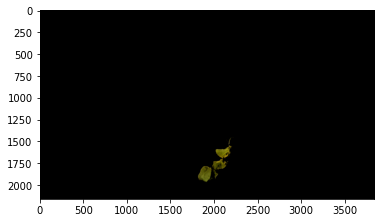

24.525906735751295 67.56217616580311 386 386 386
24.40242435458499 255.0 10807 10807 10807
28.825601374570446 49.37729095074456 6984 6984 6561
24.26829268292683 67.52845528455285 123 123 123
24.654761904761905 56.892857142857146 252 252 252


In [9]:
# look for between 90 and 160 for value
# look for between 28 and 32 for hue
good_masks = []
good_color = []
for i in range(1,n_clusters):
    bitMask = (label_img == i).astype("uint8") 
    componentMask = bitMask*255
    
    result = cv.bitwise_and(hsvImage,hsvImage,mask=componentMask)
    num_pixels = np.sum(bitMask)
    num_pix2 = np.count_nonzero(bitMask)
    h,s,v = cv.split(result)
    num_pix3 = np.count_nonzero( (23.8 < h) & (h < 34.1))
    
    myHist,myVals = np.histogram(h)
    #print(myHist,myVals)
    hueAve = np.sum(h)/num_pix2
    valAve = np.sum(v)/num_pix2
    print(hueAve, valAve,num_pixels,num_pix2,num_pix3)
    if 28 < hueAve < 32 and 90 < valAve < 160 :
        corrected2 = cv.cvtColor(result, cv.COLOR_HSV2RGB)
        smallerMask = cv.resize(componentMask,(1280,720))
        smallerRGB = cv.resize(corrected2,(1280,720))
        good_masks.append(smallerMask)
        good_color.append(smallerRGB)
        
        plt.subplot(1,1,1)    
        plt.imshow(corrected2)
        plt.show()  
    
    

In [10]:
depth5_t200 = cv.imread("tank5-2021-07-21-103303-depth_nofilter_t200.png",flags=cv.IMREAD_ANYDEPTH)

depth5 = depth5_t200
depthMask1 = cv.bitwise_and(depth5,depth5,mask=good_masks[0])



In [11]:
def computeArea(depthMask):
    xd,yd = np.where((100 < depthMask) & (depthMask < 5000))
    zipped_filtered = np.column_stack((xd, yd))

    h, w = depthMask.shape

    vfovDeg = 42.750 # based on https://nifty-bartik-6a9295.netlify.app/products/bw1098obc/
    hfovDeg = 68.793 # based on depth-ai.collab json file.

    vfov = math.radians(vfovDeg)
    hfov = math.radians(hfovDeg)

    totalArea = 0
    for z in range(0, len(zipped_filtered)):
        depth = depthMask[zipped_filtered[z][0], zipped_filtered[z][1]]
    
        vpix = 2 * depth * math.tan(0.5 * vfov) / h
        hpix = 2 * depth * math.tan(0.5 * hfov) / w
        areaPix = vpix * hpix
        totalArea += areaPix
    
    return totalArea




In [12]:
mask1AreaMM2 = computeArea(depthMask1)
print("Area plant 1: ", mask1AreaMM2,"mm^2")



Area plant 1:  10322.220973765525 mm^2


In [13]:
depthMask2 = cv.bitwise_and(depth5,depth5,mask=good_masks[1])
mask2AreaMM2 = computeArea(depthMask2)


print("Area plant 2: ", mask2AreaMM2,"mm^2")


Area plant 2:  1032.6738756019786 mm^2


In [14]:
print(math.sqrt(mask2AreaMM2) /10 / 2.54, "in")

1.2651670674177713 in
